In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext line_profiler

In [2]:
from functools import partial

import time
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['text.usetex'] = True
import plotly.express as px
import plotly.graph_objects as go

In [3]:
import jax
import jax.numpy as jnp

import diffrax
import equinox as eqx
import optax

from haiku import PRNGSequence

In [4]:
import exciting_environments as excenvs

import exciting_exciting_systems as eesys
from exciting_exciting_systems.models import NeuralEulerODEPendulum
from exciting_exciting_systems.models.model_utils import simulate_ahead_with_env
from exciting_exciting_systems.models.model_training import ModelTrainer
from exciting_exciting_systems.excitation import loss_function, Exciter

from exciting_exciting_systems.utils.density_estimation import (
    update_density_estimate_single_observation, update_density_estimate_multiple_observations, DensityEstimate
)
from exciting_exciting_systems.utils.signals import aprbs
from exciting_exciting_systems.evaluation.plotting_utils import (
    plot_sequence, append_predictions_to_sequence_plot, plot_sequence_and_prediction, plot_model_performance
)

2024-05-31 15:37:34.389994: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


---

In [5]:
# setup PRNG
key = jax.random.PRNGKey(seed=33) # 21)

data_key, model_key, loader_key, key = jax.random.split(key, 4)
data_rng = PRNGSequence(data_key)

In [38]:
batch_size = 1
tau = 1e-5 # 5e-2

env = excenvs.make(
    env_id='Pendulum-v0',
    batch_size=batch_size,
    tau=tau,
    max_torque=5
)

### Test simulation:

- starting from the intial state/obs ($\mathbf{x}_0$ / $\mathbf{y}_0$)
- apply $N = 999$ actions $\mathbf{u}_0 \dots \mathbf{u}_N$ (**here**: random APRBS actions)
- which results in the state trajectory $\mathbf{x}_0 ... \mathbf{x}_N+1$ with $N+1 = 1000$ elements

In [39]:
obs, state = env.reset()
obs = obs.astype(jnp.float32)
state = state.astype(jnp.float32)
n_steps = 999

actions = aprbs(n_steps, batch_size, 1, 10, next(data_rng))

actions.shape: (1, 999, 1)
observations.shape: (1, 1000, 2)
 
 One of the trajectories:


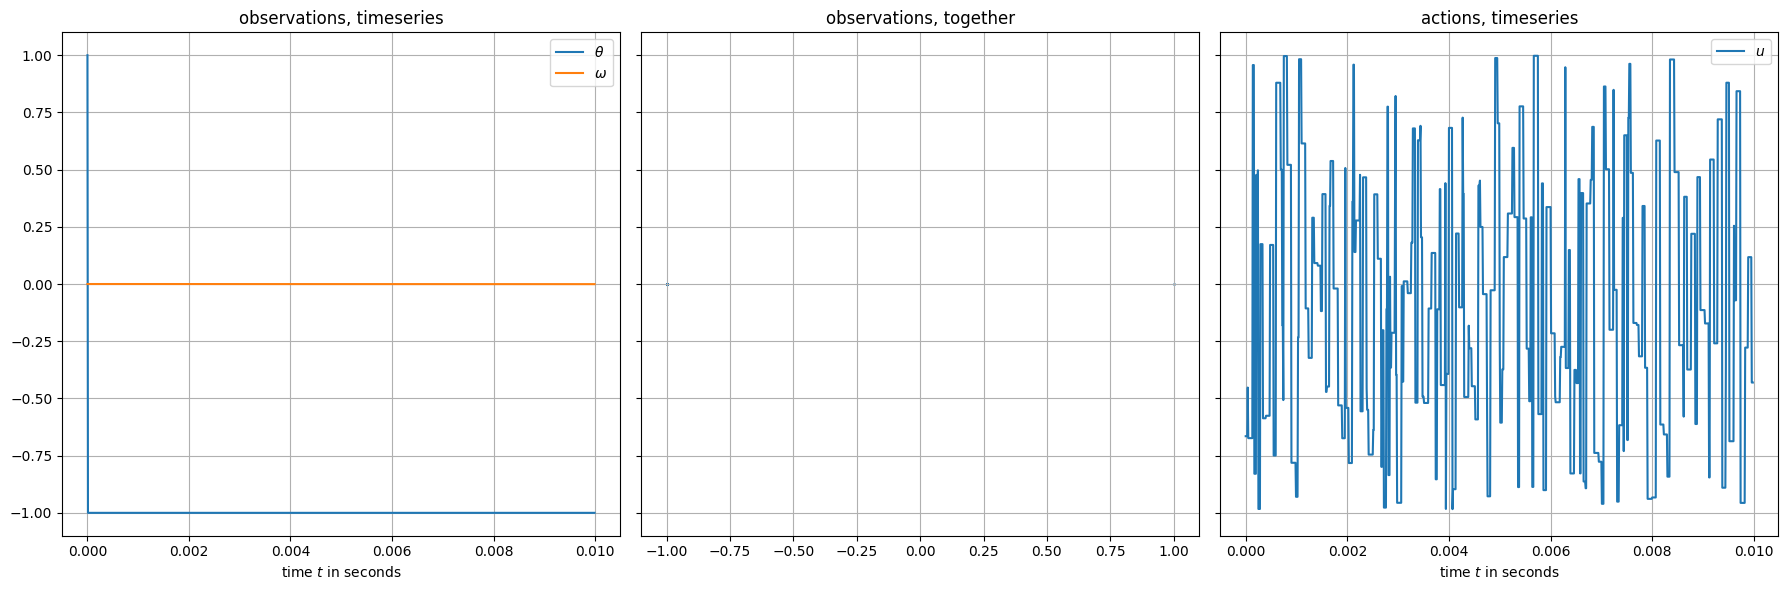

In [40]:
observations = jax.vmap(simulate_ahead_with_env, in_axes=(None, 0, 0, 0, 0, 0, 0))(
    env,
    obs,
    state,
    actions,
    env.env_state_normalizer,
    env.action_normalizer,
    env.static_params
)

print("actions.shape:", actions.shape)
print("observations.shape:", observations.shape)

print(" \n One of the trajectories:")
fig, axs = plot_sequence(
    observations=observations[0, ...],
    actions=actions[0, ...],
    tau=tau,
    obs_labels=[r"$\theta$", r"$\omega$"],
    action_labels=[r"$u$"],
);
plt.show()

## Reachability:

In [47]:
state = obs = jnp.array([[1., 1.]])
actions = jnp.ones(50_000, dtype=jnp.float32)[None, :, None]

actions.shape: (1, 50000, 1)
observations.shape: (1, 50001, 2)
 
 One of the trajectories:


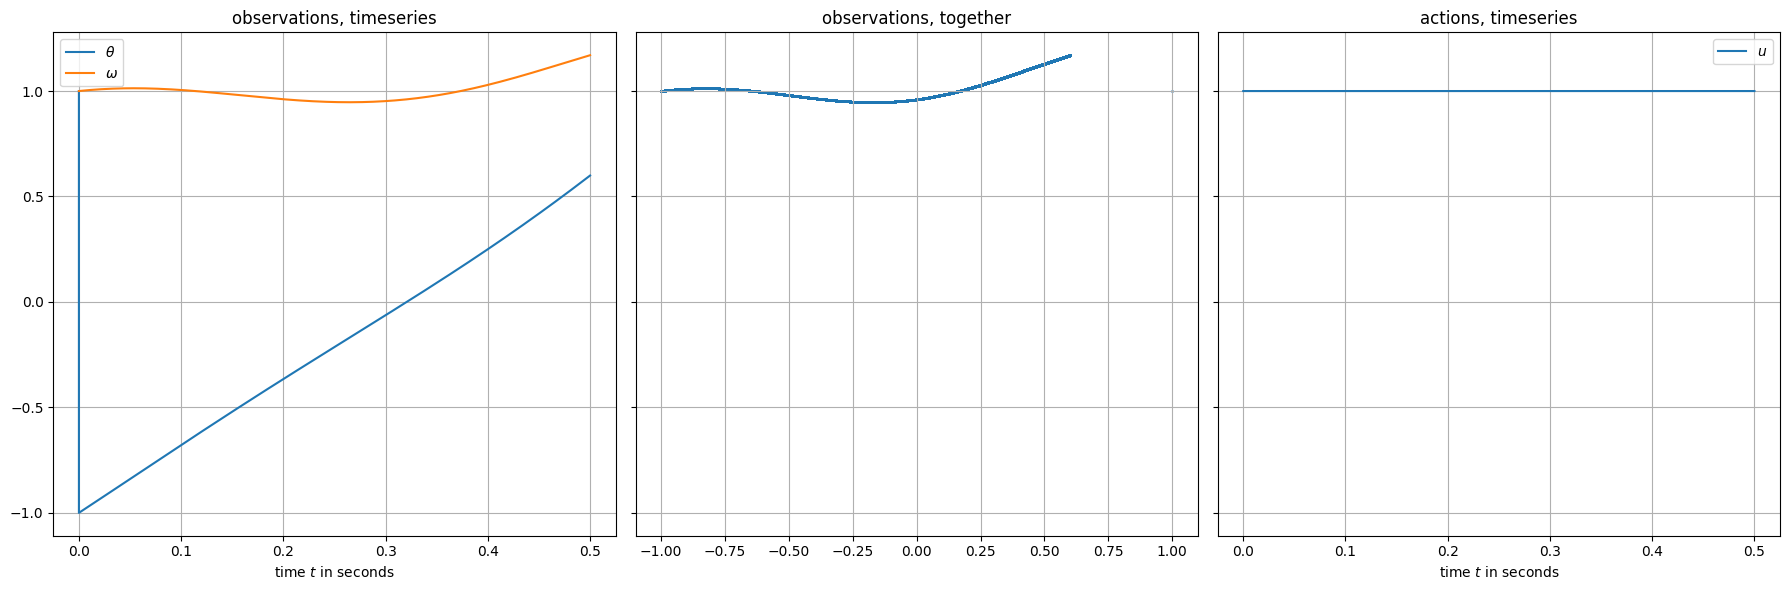

In [48]:
observations = jax.vmap(simulate_ahead_with_env, in_axes=(None, 0, 0, 0, 0, 0, 0))(
    env,
    obs,
    state,
    actions,
    env.env_state_normalizer,
    env.action_normalizer,
    env.static_params
)

print("actions.shape:", actions.shape)
print("observations.shape:", observations.shape)

print(" \n One of the trajectories:")
fig, axs = plot_sequence(
    observations=observations[0, ...],
    actions=actions[0, ...],
    tau=tau,
    obs_labels=[r"$\theta$", r"$\omega$"],
    action_labels=[r"$u$"],
);
plt.show()